In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_transaction = pd.read_csv('x_train_reduced.csv')
x_test = pd.read_csv('x_test_reduced.csv')

In [3]:
y_train = train_transaction.isFraud
train_transaction=train_transaction.drop('isFraud',axis=1)

In [7]:
print(train_transaction.shape[0])#590540

590540


In [4]:
# train_transaction = pd.concat((train_transaction, test_transaction)).reset_index(drop=True)

In [5]:
# y_train = train_transaction.isFraud
# train_transaction = train_transaction.drop('isFraud', axis=1)

In [ ]:
to_drop = (train_transaction.isna().sum()/len(train_transaction)>.90)
train_transaction = train_transaction.loc[:, ~to_drop]

### Exploring missing for engineering

#### FOR ANONYMIZED VALUES, CONSIDER K-MEANS CLUSTERING TO DERIVE VALUES

#### Engineering on V nulls

In [17]:
y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [5]:
v_cols = [col for col in train_transaction.columns if 'V' in col]

In [6]:
train_transaction[v_cols].isna().sum()

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
V6      279287
V7      279287
V8      279287
V9      279287
V10     279287
V11     279287
V12      76073
V13      76073
V14      76073
V15      76073
V16      76073
V17      76073
V18      76073
V19      76073
V20      76073
V21      76073
V22      76073
V23      76073
V24      76073
V25      76073
V26      76073
V27      76073
V28      76073
V29      76073
V30      76073
V31      76073
V32      76073
V33      76073
V34      76073
V35     168969
V36     168969
V37     168969
V38     168969
V39     168969
V40     168969
V41     168969
V42     168969
V43     168969
V44     168969
V45     168969
V46     168969
V47     168969
V48     168969
V49     168969
V50     168969
V51     168969
V52     168969
V53      77096
V54      77096
V55      77096
V56      77096
V57      77096
V58      77096
V59      77096
V60      77096
V61      77096
V62      77096
V63      77096
V64      77096
V65      77096
V66      77096
V67      7

In [6]:
v_279 = [col for col in train_transaction.columns if ((train_transaction[col].isna().sum()==279287) and (col.startswith('V')))]
v_760 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==76073)]
v_168 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==168969)]
v_770 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==77096)]
v_891 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==89164)]
v_314 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==314)]
v_595 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==508595)]
v_589 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==508589)]
v_909 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==450909)]
v_721 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==450721)]
v_460 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==460110)]
v_449 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==449124)]
v_126 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==1269)]
v_12 = [col for col in train_transaction.columns if ((train_transaction[col].isna().sum()==12) and (col.startswith('V')))]
v_189 = [col for col in train_transaction.columns if (train_transaction[col].isna().sum()==508189)]

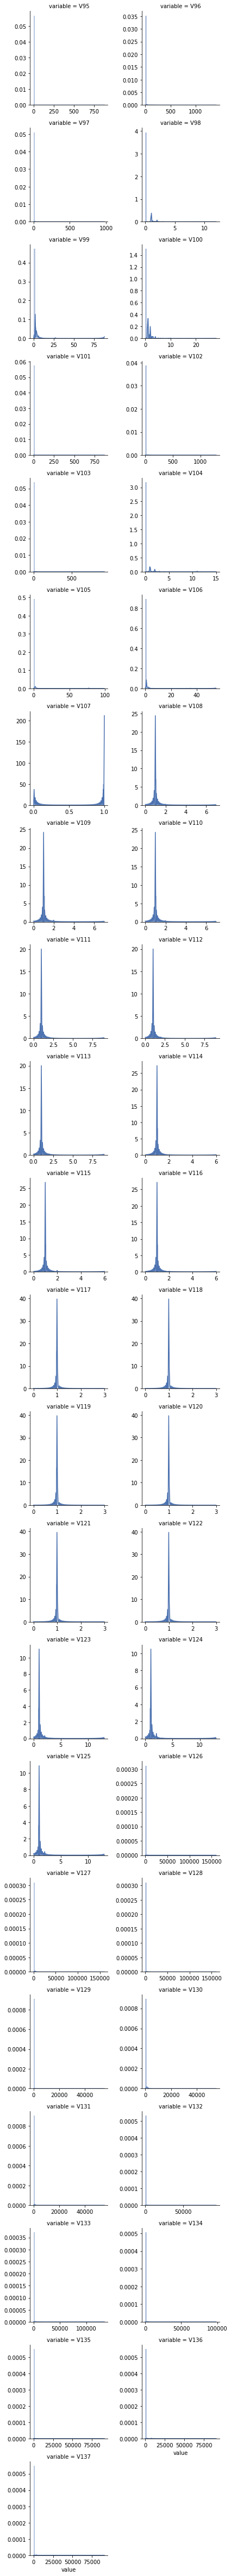

In [17]:
melted314 = pd.melt(train_transaction, value_vars=train_transaction[v_314])
sns.set_palette("deep")
melt314 = sns.FacetGrid(melted314, col="variable", palette='Set1', col_wrap=2, sharex=False, sharey=False)
melt314 = melt314.map(sns.distplot, "value")

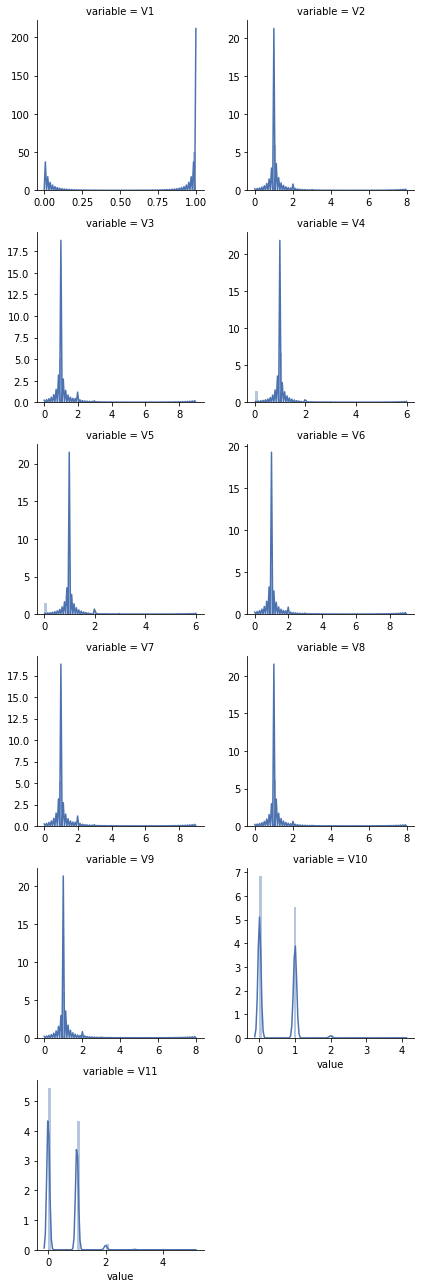

In [18]:
melted279 = pd.melt(train_transaction, value_vars=train_transaction[v_279])
sns.set_palette("deep")
melt279 = sns.FacetGrid(melted279, col="variable", palette='Set1', col_wrap=2, sharex=False, sharey=False)
melt279 = melt279.map(sns.distplot, "value")

#### May want to display the distributions another way. v_12s below show the entire distribution at 1, and a single point at 10,000 or so. May want to index in on these anomalies.

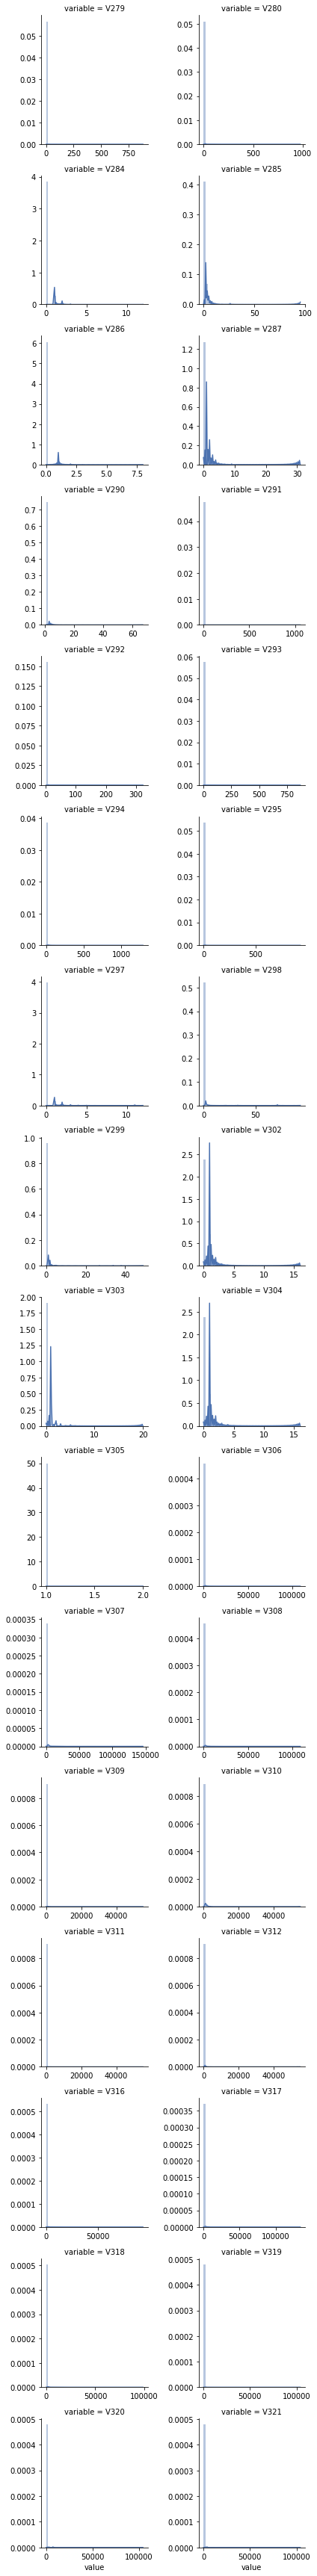

In [19]:
melted12 = pd.melt(train_transaction, value_vars=train_transaction[v_12])
sns.set_palette("deep")
melt12 = sns.FacetGrid(melted12, col="variable", palette='Set1', col_wrap=2, sharex=False, sharey=False)
melt12 = melt12.map(sns.distplot, "value")

In [7]:
train_transaction['v_279null'] = np.where(train_transaction['V1'].isna(),0,1)
train_transaction['v_760null'] = np.where(train_transaction['V12'].isna(),0,1)
train_transaction['v_168null'] = np.where(train_transaction['V35'].isna(),0,1)
train_transaction['v_770null'] = np.where(train_transaction['V53'].isna(),0,1)
train_transaction['v_891null'] = np.where(train_transaction['V75'].isna(),0,1)
train_transaction['v_314null'] = np.where(train_transaction['V95'].isna(),0,1)
train_transaction['v_595null'] = np.where(train_transaction['V138'].isna(),0,1)
train_transaction['v_589null'] = np.where(train_transaction['V143'].isna(),0,1)
train_transaction['v_909null'] = np.where(train_transaction['V167'].isna(),0,1)
train_transaction['v_721null'] = np.where(train_transaction['V208'].isna(),0,1)
train_transaction['v_460null'] = np.where(train_transaction['V217'].isna(),0,1)
train_transaction['v_449null'] = np.where(train_transaction['V234'].isna(),0,1)
train_transaction['v_126null'] = np.where(train_transaction['V279'].isna(),0,1)
train_transaction['v_12null'] = np.where(train_transaction['V318'].isna(),0,1)
train_transaction['v_189null'] = np.where(train_transaction['V322'].isna(),0,1)

In [8]:
print(train_transaction[train_transaction['V95'] == train_transaction['V98'] + train_transaction['V101']
                        + train_transaction['V104']].shape[0]/train_transaction.shape[0])

##consider making a categorical column for those that correspond with one another

0.9983388085481085


#### Engineering on id features

In [36]:
train_transaction['id_30'].value_counts()

Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
Mac OS X 10_12_6     2559
Mac OS X 10_11_6     2348
iOS 11.3.0           2016
Windows 8.1          1914
Mac OS X 10_10_5     1651
iOS 11.2.6           1647
iOS 10.3.3           1558
Mac OS X 10_13_2     1421
Mac OS X 10_13_1     1211
iOS 11.2.5           1200
Linux                1136
Android              1079
iOS 11.2.2            902
Mac OS X 10_13_3      860
iOS 11.2.0            852
Mac OS X 10_13_4      759
iOS 11.1.1            700
iOS 11.0.3            659
Android 7.1.1         630
Mac OS X 10_9_5       570
Android 6.0.1         566
iOS 10.3.2            428
iOS 9.3.5             414
Android 5.1.1         350
Android 8.0.0         343
Mac                   303
Mac OS X 10.13        287
iOS 10.2.1            285
iOS                   274
iOS 11.1.0            271
Windows Vista         246
iOS 10.3.1            236
Mac OS X 10.12        218
Mac OS X 10_

In [8]:
train_transaction.loc[train_transaction['id_30'].str.contains('Windows',na=False), 'operating_system']='Windows'
train_transaction.loc[(train_transaction['id_30'].str.contains('Mac',na=False))|
                      (train_transaction['id_30'].str.contains('OS',na=False)), 'operating_system']='Apple'
train_transaction.loc[train_transaction['id_30'].str.contains('Android',na=False), 'operating_system']='Android'

In [9]:
train_transaction.loc[(~train_transaction['id_30'].str.contains('Android',na=False))|
                      (~train_transaction['id_30'].str.contains('iOS',na=False)), 'device_type']='Desktop'
train_transaction.loc[(train_transaction['id_30'].str.contains('Android',na=False))|
                      (train_transaction['id_30'].str.contains('iOS',na=False)), 'device_type']='Mobile'

In [23]:
train_transaction['id_30'].value_counts()

Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
Mac OS X 10_12_6     2559
Mac OS X 10_11_6     2348
iOS 11.3.0           2016
Windows 8.1          1914
Mac OS X 10_10_5     1651
iOS 11.2.6           1647
iOS 10.3.3           1558
Mac OS X 10_13_2     1421
Mac OS X 10_13_1     1211
iOS 11.2.5           1200
Linux                1136
Android              1079
iOS 11.2.2            902
Mac OS X 10_13_3      860
iOS 11.2.0            852
Mac OS X 10_13_4      759
iOS 11.1.1            700
iOS 11.0.3            659
Android 7.1.1         630
Mac OS X 10_9_5       570
Android 6.0.1         566
iOS 10.3.2            428
iOS 9.3.5             414
Android 5.1.1         350
Android 8.0.0         343
Mac                   303
Mac OS X 10.13        287
iOS 10.2.1            285
iOS                   274
iOS 11.1.0            271
Windows Vista         246
iOS 10.3.1            236
Mac OS X 10.12        218
Mac OS X 10_

In [24]:
type(train_transaction['C1'][2])

numpy.float64

In [10]:
c_cols = [col for col in train_transaction.columns if 'C' in col]
train_transaction[c_cols].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092392,15.269836,0.005644,4.092183,5.571526,9.071081,2.848476,5.144554,4.480240,5.240344,10.241547,4.076252,32.539916,8.295215
std,133.566882,154.671820,0.150536,68.848425,25.786976,71.508436,61.727247,95.377850,16.674897,95.581309,94.336969,86.666957,129.364785,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4684.000000,5692.000000,26.000000,2252.000000,349.000000,2252.000000,2256.000000,3332.000000,210.000000,3256.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [28]:
c_cols  = c_cols[1:]
c_cols

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [32]:
train_transaction = pd.concat([train_transaction,y_train],axis=1)

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [54]:
train_transaction['C1test'] = np.where(train_transaction['C1']<=1,1,0)

In [55]:
c_hi = train_transaction.loc[train_transaction['C1test']==1]['isFraud']
c1 = train_transaction.groupby('C1test')['isFraud'].count()
c1 = pd.DataFrame(c1)
c_hi.describe()#### mean equal 10%

count    317285.000000
mean          0.024760
std           0.155393
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

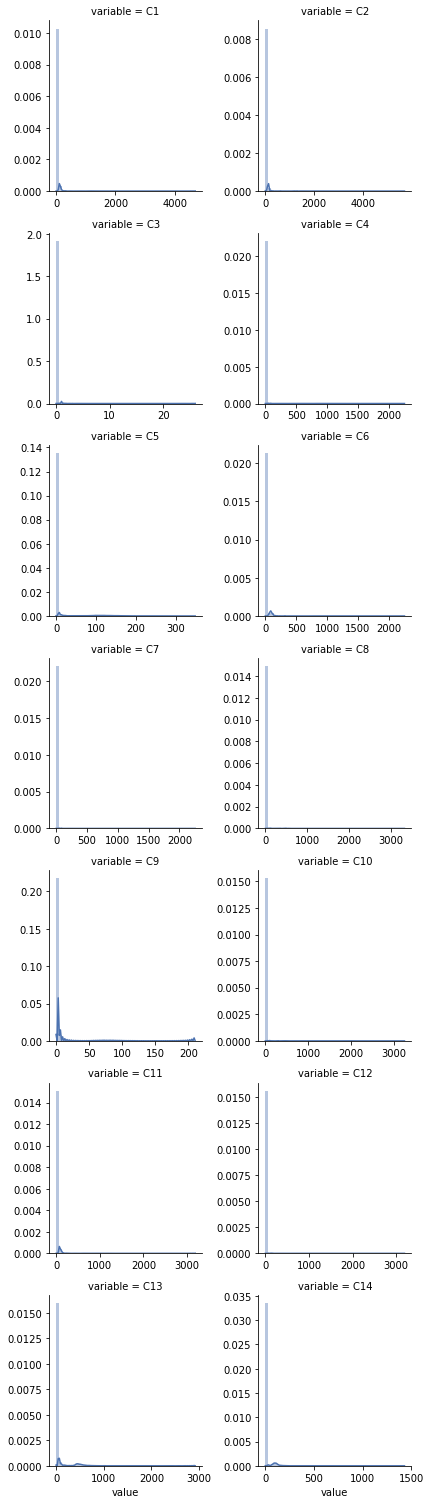

In [29]:
melted314 = pd.melt(train_transaction, value_vars=train_transaction[c_cols])
sns.set_palette("deep")
melt314 = sns.FacetGrid(melted314, col="variable", palette='Set1', col_wrap=2, sharex=False, sharey=False)
melt314 = melt314.map(sns.distplot, "value")

#### no true pattern between max and sd. Perhaps feature on the standard deviation, scale for range for range?

#### consider a feature on information ratio 

In [15]:
train_transaction['C13'].value_counts()

1.0       199337
2.0        57616
0.0        35460
3.0        33033
4.0        23704
5.0        18355
6.0        15127
7.0        13001
8.0        11424
9.0        10189
10.0        9263
11.0        8591
12.0        8442
13.0        8032
14.0        6997
15.0        6254
16.0        5838
17.0        5398
18.0        4898
19.0        4503
20.0        4135
21.0        3865
22.0        3584
23.0        3429
24.0        3271
25.0        3056
26.0        2827
27.0        2692
28.0        2588
29.0        2556
30.0        2284
31.0        2096
32.0        1887
33.0        1744
34.0        1697
35.0        1598
36.0        1382
37.0        1379
38.0        1374
61.0        1329
39.0        1273
40.0        1165
42.0        1108
41.0        1090
43.0        1062
51.0        1053
44.0         975
45.0         906
46.0         892
47.0         852
49.0         795
48.0         763
50.0         745
52.0         741
53.0         720
54.0         597
55.0         560
57.0         535
56.0         5

In [79]:
train_transaction['id_33'].value_counts()

1920x1080    16874
1366x768      8605
1334x750      6447
2208x1242     4900
1440x900      4384
1600x900      3510
2048x1536     3482
1280x800      2149
2560x1600     2093
2560x1440     1865
2880x1800     1756
1280x1024     1743
1680x1050     1727
1136x640      1712
2436x1125     1484
1280x720      1318
1920x1200     1056
2001x1125     1020
1024x768       824
2220x1080      544
5120x2880      397
3360x2100      380
2732x2048      354
1366x767       335
3840x2160      263
855x480        250
2736x1824      241
1360x768       224
4096x2304      208
2224x1668      194
2220x1081      176
2160x1440      168
2961x1442      157
3200x1800      124
2560x1080      103
2562x1442       99
1600x1200       97
1280x768        90
3000x2000       88
1024x600        88
1280x1025       82
1152x864        79
3440x1440       76
801x480         64
2400x1350       62
960x540         58
2672x1440       58
1919x1079       57
1365x768        52
1919x1080       51
2048x1152       51
2960x1440       47
1536x864    

In [83]:
train_transaction.loc[train_transaction['id_33']=='6016x3384']['id_30']

74848     Mac OS X 10_13_3
116993    Mac OS X 10_13_4
Name: id_30, dtype: object

In [15]:
####consider binning by size


train_transaction['device_size']=train_transaction['id_33'].str[:4]

train_transaction['device_size'] = train_transaction['device_size'].str.replace('x','')
        

train_transaction['device_size'] = train_transaction['device_size'].astype('O')
train_transaction.loc[train_transaction['device_size'].notnull(),
                      'device_size'] = train_transaction.loc[train_transaction['device_size'].notnull(),
                                                             'device_size'].astype(int)

In [16]:
type(train_transaction['device_size'][1])

int

In [17]:
train_transaction.loc[train_transaction['device_size']<=1000.0, 'device_size_profile']='small'
train_transaction.loc[(train_transaction['device_size']>1000.0) &
                      (train_transaction['device_size']<=1700.0), 'device_size_profile']='medium'
train_transaction.loc[(train_transaction['device_size']<1700.0) &
                      (train_transaction['device_size']<=2650.0), 'device_size_profile']='large'
train_transaction.loc[train_transaction['device_size']>2650.0, 'device_size_profile']='Xlarge'

In [20]:
train_transaction.loc[train_transaction['id_31'].str.contains('chrome',na=False), 'browser']='chrome'
train_transaction.loc[train_transaction['id_31'].str.contains('safari',na=False), 'browser']='safari'
train_transaction.loc[train_transaction['id_31'].str.contains('firefox',na=False), 'browser']='firefox'
train_transaction.loc[train_transaction['id_31'].str.contains('edge',na=False), 'browser']='edge'

### engineering on email domains

In [7]:
pattern = r"(?P<domain>[\w]+)(?P<end_domain>[\.\w+]+)"
url_parts_p = train_transaction['P_emaildomain'].str.extract(pattern, flags=re.I)

l = url_parts_p['end_domain'] == 'l'
url_parts_p[l]
url_parts_p.loc[url_parts_p['domain']=='gmai', 'end_domain']='.com'
url_parts_p.loc[url_parts_p['domain']=='gmai', 'domain']='gmail'
url_parts_p.loc[url_parts_p['domain']=='servicio', 'end_domain']='.com'
url_parts_p.loc[url_parts_p['domain']=='servicio', 'domain']='servicios'

url_parts_p.loc[(url_parts_p['end_domain']!='.com')|(url_parts_p['end_domain']!='.net')|(url_parts_p['end_domain']!='.edu'),'foreign']='yes'
url_parts_p.loc[(url_parts_p['end_domain']=='.com')|(url_parts_p['end_domain']=='.net')|(url_parts_p['end_domain']=='.edu'),'foreign']='no'

train_transaction['domain_p']=url_parts_p['domain']
train_transaction['end_domain_p']=url_parts_p['end_domain']
train_transaction['foreign_p']=url_parts_p['foreign']

train_transaction['Transaction_time_days'] = train_transaction['TransactionDT']/(86400)

In [8]:
cards = [col for col in train_transaction.columns if 'card' in col]
train_transaction = train_transaction.rename({'card4':'card_type','card6':'card_category'},axis=1)

In [9]:
v_cols = [col for col in train_transaction if col[0] == 'V']
v_d = pd.DataFrame(train_transaction[v_cols])

In [10]:
nan_12 = [col for col in v_d.columns if (v_d[col].isna().sum()/len(v_d)<.13).all()]
nan_12 = nan_12+['TransactionID','TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
                 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']

In [11]:
vnan_list = [col for col in train_transaction[nan_12].columns if 'V' in col]

for col in train_transaction[vnan_list]:
    train_transaction[col] = train_transaction[col].fillna(train_transaction.loc[train_transaction['ProductCD']=='C'][col].mean())
    train_transaction[col] = train_transaction[col].fillna(train_transaction.loc[train_transaction['ProductCD']=='W'][col].mean())
    train_transaction[col] = train_transaction[col].fillna(train_transaction.loc[train_transaction['ProductCD']=='S'][col].mean())
    train_transaction[col] = train_transaction[col].fillna(train_transaction.loc[train_transaction['ProductCD']=='R'][col].mean())
    train_transaction[col] = train_transaction[col].fillna(train_transaction.loc[train_transaction['ProductCD']=='H'][col].mean())

In [12]:
by_prod = train_transaction.groupby('ProductCD')[v_cols].agg('mean').reset_index()
by_prod = pd.melt(by_prod, id_vars='ProductCD', value_vars=[col for col in by_prod.columns if 'V' in col])
prod_means = by_prod.groupby('ProductCD')['value'].agg('mean')

train_transaction.loc[train_transaction['ProductCD']=='C', 'v_prod'] = 4.875
train_transaction.loc[train_transaction['ProductCD']=='H', 'v_prod'] = 2.655
train_transaction.loc[train_transaction['ProductCD']=='R', 'v_prod'] = 7.283
train_transaction.loc[train_transaction['ProductCD']=='S', 'v_prod'] = 549.088
train_transaction.loc[train_transaction['ProductCD']=='W', 'v_prod'] = 9.380

nan_12 = nan_12+['v_prod']

In [13]:
train_transaction['card2'] = train_transaction['card2'].astype(np.float32).fillna(round(train_transaction['card2'].mean(),0))
train_transaction['card3'] = train_transaction['card3'].fillna(train_transaction['card3'].astype(np.float32).mode()[0])
train_transaction['card_type'] = train_transaction['card_type'].fillna('visa')
train_transaction['card5'] =train_transaction['card5'].astype(np.float32).fillna(round(train_transaction['card5'].mean(),0))
train_transaction['card_category'] = train_transaction['card_category'].fillna('debit')

In [14]:
train_transaction['addr1'] =train_transaction['addr1'].fillna(round(train_transaction['addr1'].astype(np.float32).mean(),0))
train_transaction['addr2'] = train_transaction['addr2'].fillna(train_transaction['addr1'].astype(np.float32).mode()[0])
train_transaction['D1'] = train_transaction['D1'].fillna(train_transaction['D1'].astype(np.float32).mode()[0])
train_transaction['D10'] = train_transaction['D10'].fillna(train_transaction['D1'].astype(np.float32).mode()[0])

In [15]:
train_transaction['P_emaildomain'] = train_transaction['P_emaildomain'].fillna(-999)
train_transaction['domain_p'] = train_transaction['domain_p'].fillna(-999)
train_transaction['end_domain_p'] = train_transaction['end_domain_p'].fillna(-999)

### Cutting Cols and imputing on V Mean

In [16]:
def cuttingq(df):
    for col in df:
        if len(df[col].unique()) >= 500:
            df[col+'_binnedq']=pd.qcut(df[col], 25, duplicates='drop', labels = False)
        elif (len(df[col].unique()) >= 100 and len(df[col].unique())<=400):
            df[col+'_binnedq']=pd.qcut(df[col], 15,duplicates='drop', labels = False)
        else:
            df[col+'_binnedq']=pd.qcut(df[col], 8 ,duplicates='drop', labels = False)

In [17]:
def cutting(df):
    for col in df:
        if len(df[col].unique()) >= 500:
            df[col+'_binned']=pd.cut(df[col], bins=25, labels = range(1,26))
        elif (len(df[col].unique()) >= 100 and len(df[col].unique())<=400):
            df[col+'_binned']=pd.cut(df[col], bins=15, labels = range(1,16))
        else:
            df[col+'_binned']=pd.cut(df[col], bins=8, labels = range(1,9))
        df[col] = df[col].astype(int)

In [18]:
cols_to_cut = ['D1','D10','card2','card3','card5','addr1','addr2']
cut_cols = train_transaction[cols_to_cut]
cutting(cut_cols)

In [19]:
cut_colsq = cut_cols.copy()
cutcolsq= cuttingq(cut_colsq)

In [51]:
cut_colsq.head()

,D1,D10,card2,card3,card5,addr1,addr2,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,addr2_binnedq
0,14.0,13.0,363.0,150.0,142.0,315.0,87.0,2,1,10,0,2,8,0
1,0.0,0.0,404.0,150.0,102.0,325.0,87.0,0,0,12,0,0,9,0
2,0.0,0.0,490.0,150.0,166.0,330.0,87.0,0,0,14,0,2,10,0
3,112.0,84.0,567.0,150.0,117.0,476.0,87.0,7,5,19,0,0,13,0
4,0.0,0.0,514.0,150.0,102.0,420.0,87.0,0,0,16,0,0,11,0


In [20]:
cut_colsq = cut_colsq.drop([col for col in cut_cols.columns if 'binned' not in col], axis=1)
train_transaction = pd.concat([train_transaction,cut_colsq],axis=1)
train_transaction = train_transaction.loc[:,~train_transaction.columns.duplicated()]

In [48]:
cut_colsq.head()

,D1_binned,D10_binned,card2_binned,card3_binned,card5_binned,addr1_binned,addr2_binned
0,1,1,14,6,5,8,3
1,1,1,16,6,1,8,3
2,1,1,20,6,8,8,3
3,5,3,24,6,2,13,3
4,1,1,21,6,1,11,3


In [19]:
train_transaction=train_transaction.drop([col for col in train_transaction.columns if 'binned_binned' in col],axis=1)

In [54]:
train_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,...,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,Transaction_time_days,v_prod,D1_binned,D10_binned,card2_binned,card3_binned,card5_binned,addr1_binned,addr2_binned,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,addr2_binnedq
0,2987000,86400,68.5,W,13926,363.0,150.0,discover,142.0,credit,315.0,87.0,19.0,missing,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing,missing,yes,1.000000,9.380,1,1,14,6,5,8,3,2,1,10,0,2,8,0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,.com,no,1.000012,9.380,1,1,16,6,1,8,3,0,0,12,0,0,9,0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,.com,no,1.000799,9.380,1,1,20,6,8,8,3,0,0,14,0,2,10,0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,...,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,.com,no,1.001146,9.380,5,3,24,6,2,13,3,7,5,19,0,0,13,0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gmail,.com,no,1.001227,2.655,1,1,21,6,1,11,3,0,0,16,0,0,11,0


In [39]:
cols_melt = [col for col in train_transaction.columns if ((train_transaction[col].isna().sum()==0) and ('V' in col))]

cols_melt = [col for col in train_transaction.columns if 'V' in col]
cols_melt2 = [col for col in train_transaction.columns if 'binned' in col]
cols_3 = cols_melt + cols_melt2
cols_melt_fin = train_transaction[cols_3]


# v_cols_melt = [col for col in cols_melt.columns if col.startswith('V')]
cols_melt_fin.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,D1_binned,D10_binned,card2_binned,card3_binned,card5_binned,addr1_binned,addr2_binned
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.00000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,14,6,5,8,3
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.000000,0.00000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,16,6,1,8,3
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.00000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,20,6,8,8,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.000000,0.00000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,24,6,2,13,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.999969,0.96801,0.976854,0.910983,0.916612,0.96801,0.976854,0.877809,0.883376,1.076683,1.085849,0.967887,0.976731,0.0,0.0,0.0,0.0,0.967949,0.976792,0.967826,0.976669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,21,6,1,11,3


In [121]:
def melt_v(df):
    melted_dict = {}
    for col in df:
        v_cols_melt = [col for col in df.columns if col.startswith('V')]
        if not re.match('V',col):
            by = df.groupby(col)[v_cols_melt].agg('mean').reset_index()
            melter = pd.melt(by, id_vars=col, value_vars=[col for col in df.columns if 'V' in col])
            meaner = melter.groupby(col)['value'].agg('mean')
            melted_dict[col]=meaner  
    return melted_dict  

#### Melt only columns with correlatated missingness. Consult the distplots to see if scaling them is necessary

In [ ]:
melted_avs = melt_v(cols_melt_fin)
melted_avs = pd.DataFrame(melted_avs)

In [173]:
melted_avs.head()

,D1_binned,D10_binned,card2_binned,card3_binned,card5_binned,addr1_binned,addr2_binned
0,4.191316,5.346076,9.789744,18.866969,101.313953,9.649722,18.772135
1,18.692579,17.505202,5.143234,1.788879,5.095726,9.393940,4.528474
2,15.523047,15.146021,8.370349,2.737216,5.444854,11.321007,NaN
3,15.272217,12.212634,7.757718,NaN,16.862267,7.164139,NaN
4,237.553162,10.282737,6.122031,NaN,7.130502,8.450632,NaN


In [21]:
train_transaction.loc[train_transaction['addr1_binnedq']==0, 'addr1_binnedq']=9.650
train_transaction.loc[train_transaction['addr1_binnedq']==1, 'addr1_binnedq']=9.394
train_transaction.loc[train_transaction['addr1_binnedq']==2, 'addr1_binnedq']=11.321
train_transaction.loc[train_transaction['addr1_binnedq']==3, 'addr1_binnedq']=7.164
train_transaction.loc[train_transaction['addr1_binnedq']==4, 'addr1_binnedq']=8.451
train_transaction.loc[train_transaction['addr1_binnedq']==5, 'addr1_binnedq']=6.971
train_transaction.loc[train_transaction['addr1_binnedq']==6, 'addr1_binnedq']=4.504
train_transaction.loc[train_transaction['addr1_binnedq']==7, 'addr1_binnedq']=7.089
train_transaction.loc[train_transaction['addr1_binnedq']==8, 'addr1_binnedq']=6.377
train_transaction.loc[train_transaction['addr1_binnedq']==9, 'addr1_binnedq']=10.359
train_transaction.loc[train_transaction['addr1_binnedq']==10, 'addr1_binnedq']=159.116
train_transaction.loc[train_transaction['addr1_binnedq']==11, 'addr1_binnedq']=7.876
train_transaction.loc[train_transaction['addr1_binnedq']==12, 'addr1_binnedq']=8.738
train_transaction.loc[train_transaction['addr1_binnedq']==13, 'addr1_binnedq']=9.052

In [22]:
train_transaction.loc[train_transaction['card5_binnedq']==0, 'card5_binnedq']=101.314
train_transaction.loc[train_transaction['card5_binnedq']==1, 'card5_binnedq']=5.096
train_transaction.loc[train_transaction['card5_binnedq']==2, 'card5_binnedq']=5.445
train_transaction.loc[train_transaction['card5_binnedq']==3, 'card5_binnedq']=16.862
train_transaction.loc[train_transaction['card5_binnedq']==4, 'card5_binnedq']=7.131
train_transaction.loc[train_transaction['card5_binnedq']==5, 'card5_binnedq']=8.888
train_transaction.loc[train_transaction['card5_binnedq']==6, 'card5_binnedq']=7.198

In [23]:
train_transaction.loc[train_transaction['card3_binnedq']==0, 'card3_binnedq']=18.867
train_transaction.loc[train_transaction['card3_binnedq']==1, 'card3_binnedq']=1.789
train_transaction.loc[train_transaction['card3_binnedq']==2, 'card3_binnedq']=2.737

In [24]:
train_transaction.loc[train_transaction['card2_binnedq']==0, 'card2_binnedq']=9.79
train_transaction.loc[train_transaction['card2_binnedq']==1, 'card2_binnedq']=5.143
train_transaction.loc[train_transaction['card2_binnedq']==2, 'card2_binnedq']=8.370
train_transaction.loc[train_transaction['card2_binnedq']==3, 'card2_binnedq']=7.758
train_transaction.loc[train_transaction['card2_binnedq']==4, 'card2_binnedq']=6.122
train_transaction.loc[train_transaction['card2_binnedq']==5, 'card2_binnedq']=7.393
train_transaction.loc[train_transaction['card2_binnedq']==6, 'card2_binnedq']=7.189
train_transaction.loc[train_transaction['card2_binnedq']==7, 'card2_binnedq']=8.929
train_transaction.loc[train_transaction['card2_binnedq']==8, 'card2_binnedq']=5.431
train_transaction.loc[train_transaction['card2_binnedq']==9, 'card2_binnedq']=7.525
train_transaction.loc[train_transaction['card2_binnedq']==10, 'card2_binnedq']=9.423
train_transaction.loc[train_transaction['card2_binnedq']==11, 'card2_binnedq']=8.632
train_transaction.loc[train_transaction['card2_binnedq']==12, 'card2_binnedq']=5.274
train_transaction.loc[train_transaction['card2_binnedq']==13, 'card2_binnedq']=6.883
train_transaction.loc[train_transaction['card2_binnedq']==14, 'card2_binnedq']=119.662
train_transaction.loc[train_transaction['card2_binnedq']==15, 'card2_binnedq']=5.583
train_transaction.loc[train_transaction['card2_binnedq']==16, 'card2_binnedq']=11.277
train_transaction.loc[train_transaction['card2_binnedq']==17, 'card2_binnedq']=4.031
train_transaction.loc[train_transaction['card2_binnedq']==18, 'card2_binnedq']=7.107
train_transaction.loc[train_transaction['card2_binnedq']==19, 'card2_binnedq']=10.141
train_transaction.loc[train_transaction['card2_binnedq']==20, 'card2_binnedq']=7.199

In [25]:
train_transaction.loc[train_transaction['D10_binnedq']==0, 'D10_binnedq']=5.346
train_transaction.loc[train_transaction['D10_binnedq']==1, 'D10_binnedq']=17.505
train_transaction.loc[train_transaction['D10_binnedq']==2, 'D10_binnedq']=15.146
train_transaction.loc[train_transaction['D10_binnedq']==3, 'D10_binnedq']=12.213
train_transaction.loc[train_transaction['D10_binnedq']==4, 'D10_binnedq']=10.283
train_transaction.loc[train_transaction['D10_binnedq']==5, 'D10_binnedq']=10.315
train_transaction.loc[train_transaction['D10_binnedq']==6, 'D10_binnedq']=12.644
train_transaction.loc[train_transaction['D10_binnedq']==7, 'D10_binnedq']=11.713
train_transaction.loc[train_transaction['D10_binnedq']==8, 'D10_binnedq']=230.930
train_transaction.loc[train_transaction['D10_binnedq']==9, 'D10_binnedq']=12.177
train_transaction.loc[train_transaction['D10_binnedq']==10, 'D10_binnedq']=9.029
train_transaction.loc[train_transaction['D10_binnedq']==11, 'D10_binnedq']=10.852
train_transaction.loc[train_transaction['D10_binnedq']==12, 'D10_binnedq']=7.982

In [26]:
train_transaction.loc[train_transaction['D1_binnedq']==0, 'D1_binnedq']=4.191
train_transaction.loc[train_transaction['D1_binnedq']==1, 'D1_binnedq']=18.693
train_transaction.loc[train_transaction['D1_binnedq']==2, 'D1_binnedq']=15.523
train_transaction.loc[train_transaction['D1_binnedq']==3, 'D1_binnedq']=15.272
train_transaction.loc[train_transaction['D1_binnedq']==4, 'D1_binnedq']=237.553
train_transaction.loc[train_transaction['D1_binnedq']==5, 'D1_binnedq']=13.564
train_transaction.loc[train_transaction['D1_binnedq']==6, 'D1_binnedq']=10.700
train_transaction.loc[train_transaction['D1_binnedq']==7, 'D1_binnedq']=10.735
train_transaction.loc[train_transaction['D1_binnedq']==8, 'D1_binnedq']=13.819
train_transaction.loc[train_transaction['D1_binnedq']==9, 'D1_binnedq']=10.352
train_transaction.loc[train_transaction['D1_binnedq']==10, 'D1_binnedq']=9.218
train_transaction.loc[train_transaction['D1_binnedq']==11, 'D1_binnedq']=7.847
train_transaction.loc[train_transaction['D1_binnedq']==12, 'D1_binnedq']=10.688
train_transaction.loc[train_transaction['D1_binnedq']==13, 'D1_binnedq']=15.493

### Binned not Qcut

#### Since your binning by quartile, don't exceed an unnecessary amount, or length of quartiles will be more and more imbalanced

In [63]:
train_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,...,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,Transaction_time_days,v_prod,D1_binned,D10_binned,card2_binned,card3_binned,card5_binned,addr1_binned,addr2_binned,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,addr2_binnedq
0,2987000,86400,68.5,W,13926,363.0,150.0,discover,142.0,credit,315.0,87.0,19.0,missing,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing,missing,yes,1.000000,9.380,1,1,14,6,5,8,3,15.523,17.505,9.423,18.867,5.445,6.377,0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,.com,no,1.000012,9.380,1,1,16,6,1,8,3,4.191,5.346,5.274,18.867,101.314,10.359,0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,.com,no,1.000799,9.380,1,1,20,6,8,8,3,4.191,5.346,119.662,18.867,5.445,159.116,0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,...,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,.com,no,1.001146,9.380,5,3,24,6,2,13,3,10.735,10.315,10.141,18.867,101.314,9.052,0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gmail,.com,no,1.001227,2.655,1,1,21,6,1,11,3,4.191,5.346,11.277,18.867,101.314,7.876,0


In [27]:
biner = ['addr1_binned','card5_binned','card3_binned','card2_binned','D10_binned','D1_binned']
for col in train_transaction[biner]:
    train_transaction[col]=train_transaction[col].astype(float)

In [28]:
train_transaction.loc[train_transaction['addr1_binned']==1, 'addr1_binned']=10.257
train_transaction.loc[train_transaction['addr1_binned']==2, 'addr1_binned']=8.000
train_transaction.loc[train_transaction['addr1_binned']==3, 'addr1_binned']=9.319
train_transaction.loc[train_transaction['addr1_binned']==4, 'addr1_binned']=10.975
train_transaction.loc[train_transaction['addr1_binned']==5, 'addr1_binned']=10.251
train_transaction.loc[train_transaction['addr1_binned']==6, 'addr1_binned']=7.245
train_transaction.loc[train_transaction['addr1_binned']==7, 'addr1_binned']=5.629
train_transaction.loc[train_transaction['addr1_binned']==8, 'addr1_binned']=55.040
train_transaction.loc[train_transaction['addr1_binned']==9, 'addr1_binned']=8.179
train_transaction.loc[train_transaction['addr1_binned']==10, 'addr1_binned']=9.016
train_transaction.loc[train_transaction['addr1_binned']==11, 'addr1_binned']=6.349
train_transaction.loc[train_transaction['addr1_binned']==12, 'addr1_binned']=8.26
train_transaction.loc[train_transaction['addr1_binned']==13, 'addr1_binned']=9.3
train_transaction.loc[train_transaction['addr1_binned']==14, 'addr1_binned']=8.383
train_transaction.loc[train_transaction['addr1_binned']==15, 'addr1_binned']=9.283

In [29]:
train_transaction.loc[train_transaction['card5_binned']==1, 'card5_binned']=181.922
train_transaction.loc[train_transaction['card5_binned']==2, 'card5_binned']=7.799
train_transaction.loc[train_transaction['card5_binned']==3, 'card5_binned']=7.1287
train_transaction.loc[train_transaction['card5_binned']==4, 'card5_binned']=8.083
train_transaction.loc[train_transaction['card5_binned']==5, 'card5_binned']=3.729
train_transaction.loc[train_transaction['card5_binned']==6, 'card5_binned']=11.701
train_transaction.loc[train_transaction['card5_binned']==7, 'card5_binned']=9.176
train_transaction.loc[train_transaction['card5_binned']==8, 'card5_binned']=5.295
train_transaction.loc[train_transaction['card5_binned']==9, 'card5_binned']=3.365
train_transaction.loc[train_transaction['card5_binned']==10, 'card5_binned']=7.324
train_transaction.loc[train_transaction['card5_binned']==11, 'card5_binned']=20.812
train_transaction.loc[train_transaction['card5_binned']==12, 'card5_binned']=6.126
train_transaction.loc[train_transaction['card5_binned']==13, 'card5_binned']=4.925
train_transaction.loc[train_transaction['card5_binned']==14, 'card5_binned']=8.471
train_transaction.loc[train_transaction['card5_binned']==15, 'card5_binned']=7.198

In [ ]:
train_transaction['card3_binned']=pd.cut(train_transaction['card3'], bins=15, labels = range(1,16))

In [30]:
train_transaction.loc[train_transaction['card3_binned']==1, 'card3_binnedb']=2.532
train_transaction.loc[train_transaction['card3_binned']==2, 'card3_binnedb']=2.554
train_transaction.loc[train_transaction['card3_binned']==3, 'card3_binnedb']=2.891
train_transaction.loc[train_transaction['card3_binned']==4, 'card3_binnedb']=2.837
train_transaction.loc[train_transaction['card3_binned']==5, 'card3_binnedb']=3.759
train_transaction.loc[train_transaction['card3_binned']==6, 'card3_binnedb']=19.045
train_transaction.loc[train_transaction['card3_binned']==7, 'card3_binnedb']=29.097
train_transaction.loc[train_transaction['card3_binned']==8, 'card3_binnedb']=2.589
train_transaction.loc[train_transaction['card3_binned']==9, 'card3_binnedb']=2.423
train_transaction.loc[train_transaction['card3_binned']==10, 'card3_binnedb']=1.737
train_transaction.loc[train_transaction['card3_binned']==11, 'card3_binnedb']=2.515
train_transaction.loc[train_transaction['card3_binned']==12, 'card3_binnedb']=2.922
train_transaction.loc[train_transaction['card3_binned']==13, 'card3_binnedb']=2.2369
train_transaction.loc[train_transaction['card3_binned']==14, 'card3_binnedb']=2.845
train_transaction.loc[train_transaction['card3_binned']==15, 'card3_binnedb']=3.366

In [31]:
train_transaction.loc[train_transaction['card2_binned']==1, 'card2_binned']=9.687
train_transaction.loc[train_transaction['card2_binned']==2, 'card2_binned']=5.788
train_transaction.loc[train_transaction['card2_binned']==3, 'card2_binned']=5.125
train_transaction.loc[train_transaction['card2_binned']==4, 'card2_binned']=8.588
train_transaction.loc[train_transaction['card2_binned']==5, 'card2_binned']=7.661
train_transaction.loc[train_transaction['card2_binned']==6, 'card2_binned']=6.099
train_transaction.loc[train_transaction['card2_binned']==7, 'card2_binned']=7.479
train_transaction.loc[train_transaction['card2_binned']==8, 'card2_binned']=9.574
train_transaction.loc[train_transaction['card2_binned']==9, 'card2_binned']=6.827
train_transaction.loc[train_transaction['card2_binned']==10, 'card2_binned']=6.251
train_transaction.loc[train_transaction['card2_binned']==11, 'card2_binned']=11.05
train_transaction.loc[train_transaction['card2_binned']==12, 'card2_binned']=9.4
train_transaction.loc[train_transaction['card2_binned']==13, 'card2_binned']=5.563
train_transaction.loc[train_transaction['card2_binned']==14, 'card2_binned']=7.648
train_transaction.loc[train_transaction['card2_binned']==15, 'card2_binned']=10.946
train_transaction.loc[train_transaction['card2_binned']==16, 'card2_binned']=5.249
train_transaction.loc[train_transaction['card2_binned']==17, 'card2_binned']=4.945
train_transaction.loc[train_transaction['card2_binned']==18, 'card2_binned']=6.985
train_transaction.loc[train_transaction['card2_binned']==19, 'card2_binned']=7.397
train_transaction.loc[train_transaction['card2_binned']==20, 'card2_binned']=104.197
train_transaction.loc[train_transaction['card2_binned']==21, 'card2_binned']=9.379
train_transaction.loc[train_transaction['card2_binned']==22, 'card2_binned']=11.603
train_transaction.loc[train_transaction['card2_binned']==23, 'card2_binned']=6.165
train_transaction.loc[train_transaction['card2_binned']==24, 'card2_binned']=8.914
train_transaction.loc[train_transaction['card2_binned']==25, 'card2_binned']=10.703

In [32]:
train_transaction.loc[train_transaction['D10_binned']==1, 'D10_binned']=6.895
train_transaction.loc[train_transaction['D10_binned']==2, 'D10_binned']=10.903
train_transaction.loc[train_transaction['D10_binned']==3, 'D10_binned']=10.344
train_transaction.loc[train_transaction['D10_binned']==4, 'D10_binned']=11.033
train_transaction.loc[train_transaction['D10_binned']==5, 'D10_binned']=15.483
train_transaction.loc[train_transaction['D10_binned']==6, 'D10_binned']=10.858
train_transaction.loc[train_transaction['D10_binned']==7, 'D10_binned']=10.790
train_transaction.loc[train_transaction['D10_binned']==8, 'D10_binned']=446.032
train_transaction.loc[train_transaction['D10_binned']==9, 'D10_binned']=11.619
train_transaction.loc[train_transaction['D10_binned']==10, 'D10_binned']=11.285
train_transaction.loc[train_transaction['D10_binned']==11, 'D10_binned']=13.516
train_transaction.loc[train_transaction['D10_binned']==12, 'D10_binned']=9.516
train_transaction.loc[train_transaction['D10_binned']==13, 'D10_binned']=9.814
train_transaction.loc[train_transaction['D10_binned']==14, 'D10_binned']=10.004
train_transaction.loc[train_transaction['D10_binned']==15, 'D10_binned']=10.079
train_transaction.loc[train_transaction['D10_binned']==16, 'D10_binned']=9.194
train_transaction.loc[train_transaction['D10_binned']==17, 'D10_binned']=7.072
train_transaction.loc[train_transaction['D10_binned']==18, 'D10_binned']=9.005
train_transaction.loc[train_transaction['D10_binned']==19, 'D10_binned']=9.046
train_transaction.loc[train_transaction['D10_binned']==20, 'D10_binned']=4.946
train_transaction.loc[train_transaction['D10_binned']==21, 'D10_binned']=3.003
train_transaction.loc[train_transaction['D10_binned']==22, 'D10_binned']=4.059
train_transaction.loc[train_transaction['D10_binned']==23, 'D10_binned']=3.209
train_transaction.loc[train_transaction['D10_binned']==24, 'D10_binned']=2.062
train_transaction.loc[train_transaction['D10_binned']==25, 'D10_binned']=17.511481

In [33]:
train_transaction.loc[train_transaction['D1_binned']==1, 'D1_binned']=6.243
train_transaction.loc[train_transaction['D1_binned']==2, 'D1_binned']=152.737
train_transaction.loc[train_transaction['D1_binned']==3, 'D1_binned']=10.959
train_transaction.loc[train_transaction['D1_binned']==4, 'D1_binned']=10.709
train_transaction.loc[train_transaction['D1_binned']==5, 'D1_binned']=10.803
train_transaction.loc[train_transaction['D1_binned']==6, 'D1_binned']=11.799
train_transaction.loc[train_transaction['D1_binned']==7, 'D1_binned']=15.909
train_transaction.loc[train_transaction['D1_binned']==8, 'D1_binned']=11.542
train_transaction.loc[train_transaction['D1_binned']==9, 'D1_binned']=9.314
train_transaction.loc[train_transaction['D1_binned']==10, 'D1_binned']=8.705
train_transaction.loc[train_transaction['D1_binned']==11, 'D1_binned']=11.481
train_transaction.loc[train_transaction['D1_binned']==12, 'D1_binned']=8.172
train_transaction.loc[train_transaction['D1_binned']==13, 'D1_binned']=8.523
train_transaction.loc[train_transaction['D1_binned']==14, 'D1_binned']=7.525
train_transaction.loc[train_transaction['D1_binned']==15, 'D1_binned']=6.98
train_transaction.loc[train_transaction['D1_binned']==16, 'D1_binned']=8.515
train_transaction.loc[train_transaction['D1_binned']==17, 'D1_binned']=7.747
train_transaction.loc[train_transaction['D1_binned']==18, 'D1_binned']=7.257
train_transaction.loc[train_transaction['D1_binned']==19, 'D1_binned']=9.256
train_transaction.loc[train_transaction['D1_binned']==20, 'D1_binned']=16.841
train_transaction.loc[train_transaction['D1_binned']==21, 'D1_binned']=15.738
train_transaction.loc[train_transaction['D1_binned']==22, 'D1_binned']=15.413
train_transaction.loc[train_transaction['D1_binned']==23, 'D1_binned']=13.251
train_transaction.loc[train_transaction['D1_binned']==24, 'D1_binned']=17.017
train_transaction.loc[train_transaction['D1_binned']==25, 'D1_binned']=16.497

In [34]:
train_transaction = train_transaction.drop(['card3_binned', 'addr2_binned', 'addr2_binnedq'],axis=1)

In [158]:
by_add2 = train_transaction.groupby('addr2_binnedq')[v_cols].agg('mean').reset_index()
by_add2 = pd.melt(by_add2, id_vars='addr2_binnedq', value_vars=[col for col in by_add2.columns if 'V' in col])
add2_means = by_add2.groupby('addr2_binnedq')['value'].agg('mean')
print(add2_means)

addr2_binnedq
0    18.772135
1     4.528474
Name: value, dtype: float64


.

### Datetime Engineering

In [35]:
train_transaction['hours'] = train_transaction['Transaction_time_days'].astype(str).str[-7:-1].astype(float).apply(lambda x: x/41666.625)
train_transaction['hours'] = train_transaction['hours'].astype(int)

In [36]:
train_transaction.loc[train_transaction['hours']==0,'time_of_day']='12AM'
train_transaction.loc[train_transaction['hours']==1,'time_of_day']='1AM'
train_transaction.loc[train_transaction['hours']==2,'time_of_day']='2AM'
train_transaction.loc[train_transaction['hours']==3,'time_of_day']='3AM'
train_transaction.loc[train_transaction['hours']==4,'time_of_day']='4AM'
train_transaction.loc[train_transaction['hours']==5,'time_of_day']='5AM'
train_transaction.loc[train_transaction['hours']==6,'time_of_day']='6AM'
train_transaction.loc[train_transaction['hours']==7,'time_of_day']='7AM'
train_transaction.loc[train_transaction['hours']==8,'time_of_day']='8AM'
train_transaction.loc[train_transaction['hours']==9,'time_of_day']='9AM'
train_transaction.loc[train_transaction['hours']==10,'time_of_day']='10AM'
train_transaction.loc[train_transaction['hours']==11,'time_of_day']='11AM'
train_transaction.loc[train_transaction['hours']==12,'time_of_day']='12PM'
train_transaction.loc[train_transaction['hours']==13,'time_of_day']='1PM'
train_transaction.loc[train_transaction['hours']==14,'time_of_day']='2PM'
train_transaction.loc[train_transaction['hours']==15,'time_of_day']='3PM'
train_transaction.loc[train_transaction['hours']==16,'time_of_day']='4PM'
train_transaction.loc[train_transaction['hours']==17,'time_of_day']='5PM'
train_transaction.loc[train_transaction['hours']==18,'time_of_day']='6PM'
train_transaction.loc[train_transaction['hours']==19,'time_of_day']='7PM'
train_transaction.loc[train_transaction['hours']==20,'time_of_day']='8PM'
train_transaction.loc[train_transaction['hours']==21,'time_of_day']='9PM'
train_transaction.loc[train_transaction['hours']==22,'time_of_day']='10PM'
train_transaction.loc[train_transaction['hours']==23,'time_of_day']='11PM'

In [37]:
train_transaction.loc[(train_transaction['hours']!=16)|(train_transaction['hours']!=17)|(train_transaction['hours']!=18)|
                      (train_transaction['hours']!=19), 'rush_hour']=0
train_transaction.loc[(train_transaction['hours']==16)|(train_transaction['hours']==17)|(train_transaction['hours']==18)|
                      (train_transaction['hours']==19), 'rush_hour']=1

train_transaction['rush_hour'].value_counts()

0.0    865480
1.0    231751
Name: rush_hour, dtype: int64

In [38]:
train_transaction.loc[(train_transaction['hours']!=21)|(train_transaction['hours']!=22)|(train_transaction['hours']!=23)|
                      (train_transaction['hours']!=0)|(train_transaction['hours']!=1), 'party_hours']=0
train_transaction.loc[(train_transaction['hours']==21)|(train_transaction['hours']==22)|(train_transaction['hours']==23)|
                      (train_transaction['hours']==0)|(train_transaction['hours']==1), 'party_hours']=1

In [82]:
pattern = r'(\d+).(\d+)'

for x in train_transaction['Transaction_time_days'].astype(str)[1:]:
    days = re.compile(pattern) 
    mo = days.search(x)
    train_transaction['transaction_day'] = mo.group(1)
    

KeyboardInterrupt: 

In [70]:
for x in train_transaction['Transaction_time_days'].astype(float):
    train_transaction['transaction_day'] = int(x)

KeyboardInterrupt: 

In [325]:
train_transaction['transaction_day'] = train_transaction['Transaction_time_days'].astype(int)

ValueError: invalid literal for int() with base 10: '1.0'

In [81]:
train_transaction['transaction_day'].value_counts()

22    590540
Name: transaction_day, dtype: int64

.

### Create Random Column

In [39]:
train_transaction.shape[0]
train_transaction['random'] = np.random.randint(1, 5000000, train_transaction.shape[0])
scaler = StandardScaler()
train_transaction['random'] = scaler.fit_transform(train_transaction[['random']])

## Imputing ambiguous

In [40]:
train_transaction['M4'] = train_transaction['M4'].fillna(-999)

In [157]:
train_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,Transaction_time_days,v_prod,D1_binned,D10_binned,card2_binned,card5_binned,addr1_binned,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,hours,time_of_day,rush_hour,party_hours,transaction_day,random,amount_description
0,2987000,86400,68.5,W,13926,363.0,150.0,discover,142.0,credit,315.0,87.0,19.0,missing,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,T,T,T,M2,F,T,missing,...,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,missing,missing,yes,1.000000,9.380,1.0,1.0,14,5,8,15.523,17.505,9.423,18.867,5.445,6.377,0,12AM,False,True,7,-0.492203,more than minimal
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,-999.0,gmail.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,missing,missing,missing,M0,T,T,missing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,1.000012,9.380,1.0,1.0,16,1,8,4.191,5.346,5.274,18.867,101.314,10.359,9,9AM,False,False,7,-1.355951,more than minimal
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,-999.0,315.0,T,T,T,M0,F,F,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,outlook,.com,no,1.000799,9.380,1.0,1.0,20,8,8,4.191,5.346,119.662,18.867,5.445,159.116,2,2AM,False,False,7,1.252541,more than minimal
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,-999.0,yahoo.com,missing,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,-999.0,111.0,missing,missing,missing,M0,T,F,missing,...,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,yahoo,.com,no,1.001146,9.380,5.0,3.0,24,2,13,10.735,10.315,10.141,18.867,101.314,9.052,8,8AM,False,False,7,-0.943611,more than minimal
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,-999.0,gmail.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,missing,missing,missing,missing,missing,missing,missing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gmail,.com,no,1.001227,2.655,1.0,1.0,21,1,11,4.191,5.346,11.277,18.867,101.314,7.876,4,4AM,False,False,7,-0.756175,more than minimal


In [41]:
to_imp = [col for col in train_transaction.columns if ('V' or 'D' or 'C' or 'dist') in col]

for col in train_transaction[to_imp]:
    train_transaction[col] = train_transaction[col].fillna(-999)

In [42]:
train_transaction.loc[train_transaction['TransactionAmt']<20,'amount_description']=0
train_transaction.loc[(train_transaction['TransactionAmt']>=20)&
                      (train_transaction['TransactionAmt']<100),'amount_description']=1
train_transaction.loc[(train_transaction['TransactionAmt']>=100)&
                      (train_transaction['TransactionAmt']<500),'amount_description']=2
train_transaction.loc[(train_transaction['TransactionAmt']>=500)&
                      (train_transaction['TransactionAmt']<1500),'amount_description']=3
train_transaction.loc[(train_transaction['TransactionAmt']>=1500)&
                      (train_transaction['TransactionAmt']<9000),'amount_description']=4
train_transaction.loc[train_transaction['TransactionAmt']>9000,'amount_description']=5

In [94]:
train_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,Transaction_time_days,v_prod,D1_binned,D10_binned,card2_binned,card5_binned,addr1_binned,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,hours,time_of_day,rush_hour,party_hours,transaction_day,random,amount_description
0,2987000,86400,68.5,W,13926,363.0,150.0,discover,142.0,credit,315.0,87.0,19.0,missing,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,...,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,missing,missing,yes,1.000000,9.380,1,1,14,5,8,15.523,17.505,9.423,18.867,5.445,6.377,0,12AM,False,True,7,-0.492203,more than minimal
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,1.000012,9.380,1,1,16,1,8,4.191,5.346,5.274,18.867,101.314,10.359,9,9AM,False,False,7,-1.355951,more than minimal
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,outlook,.com,no,1.000799,9.380,1,1,20,8,8,4.191,5.346,119.662,18.867,5.445,159.116,2,2AM,False,False,7,1.252541,more than minimal
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,...,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,yahoo,.com,no,1.001146,9.380,5,3,24,2,13,10.735,10.315,10.141,18.867,101.314,9.052,8,8AM,False,False,7,-0.943611,more than minimal
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gmail,.com,no,1.001227,2.655,1,1,21,1,11,4.191,5.346,11.277,18.867,101.314,7.876,4,4AM,False,False,7,-0.756175,more than minimal


In [115]:
print(train_transaction.loc[train_transaction['card_type']=='mastercard']['card1'].max())
print(train_transaction.loc[train_transaction['card_type']=='visa']['card1'].max())

18395
18396


In [43]:
mcols = [col for col in train_transaction.columns if 'M' in col]

for col in train_transaction[mcols]:
    train_transaction[col] = train_transaction[col].fillna(-999)

train_transaction['dist1'] = train_transaction['dist1'].fillna(-999)
train_transaction['R_emaildomain'] = train_transaction['R_emaildomain'].fillna(-999)   

In [44]:
train_transaction['D1_binned'] = train_transaction['D1_binned'].astype(float)
train_transaction['D10_binned'] = train_transaction['D10_binned'].astype(float)
dcols = [col for col in train_transaction.columns if 'D' in col]
# print(dcols)

for col in train_transaction[dcols]:
    
#     print(train_transaction[col].dtype)
    train_transaction[col] = train_transaction[col].fillna(-999.0)

In [45]:
train_transaction.isna().sum()>0

TransactionID            False
TransactionDT            False
TransactionAmt           False
ProductCD                False
card1                    False
card2                    False
card3                    False
card_type                False
card5                    False
card_category            False
addr1                    False
addr2                    False
dist1                    False
P_emaildomain            False
R_emaildomain            False
C1                       False
C2                       False
C3                       False
C4                       False
C5                       False
C6                       False
C7                       False
C8                       False
C9                       False
C10                      False
C11                      False
C12                      False
C13                      False
C14                      False
D1                       False
D2                       False
D3                       False
D4      

In [45]:
train_transaction1 = train_transaction.copy()
train_transaction1 = pd.concat([train_transaction1,y_train],axis=1)

In [46]:
train_transaction1.to_csv('train_t.csv', index=False)

### Feature Selection for V columns

In [158]:
v_cols = [col for col in train_transaction.columns if 'V' in col]
v_fin = train_transaction[v_cols]

MemoryError: 

### SMOTE

In [145]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [146]:
sm = SMOTE(ratio='minority', k_neighbors=6)
v_fin, y_train = sm.fit_sample(v_fin, y_train)

### Scaling for PCA, then PCA

In [149]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [151]:
scaled_v = preprocessing.scale(v_fin.T)

MemoryError: 

In [ ]:
pca = PCA()
pca.fit(scaled_v)
pca_v = pca.transform(scaled_v)

In [ ]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

In [ ]:
from matplotlib.pyplot import figure
plt.figure(figsize=(26,16))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks(rotation='vertical')
plt.ylabel('Percent of Explained Variance')
plt.xlabel('Principal Component')
plt.title('V features Scree Plot')
plt.show()

.

### Dropping Vs based on PCA

.

### One hot Encoding

In [ ]:
one_hot_prod= pd.get_dummies(first_iter_df['ProductCD'])
one_hot_prod.shape

In [ ]:
first_iter_df = pd.concat([first_iter_df,one_hot_prod], axis=1)
first_iter_df.shape

In [ ]:
V_full = first_iter_df[pd.isnull(first_iter_df['V1']) == False]
V_with_null = first_iter_df[pd.isnull(first_iter_df['V1'])]

In [ ]:
V_full = V_full.drop('ProductCD',axis=1)
V_with_null = V_with_null.drop('ProductCD',axis=1)
V_full.head()

### train_test split, K-Folds, Balancing

.

## Encoding after Imputing

In [ ]:
one_hot_prod= pd.get_dummies(first_iter_df['ProductCD'])

In [ ]:
first_iter_df = pd.concat([first_iter_df,one_hot_prod], axis=1)

In [ ]:
V_full = first_iter_df[pd.isnull(first_iter_df['V1']) == False]
V_with_null = first_iter_df[pd.isnull(first_iter_df['V1'])]

V_full = V_full.drop('ProductCD',axis=1)
V_with_null = V_with_null.drop('ProductCD',axis=1)
V_full.head()

In [ ]:
nan_12 = nan_12+['V1']
train_transaction[nan_12].head()

first_iter_df = train_transaction[nan_12]

In [ ]:
v_full_y = V_full['V1']
v_full_x = V_full.drop('V1',axis=1)

In [ ]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()
bagging= ensemble.BaggingClassifier()
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_para_forest = [{
    "n_estimators": [25, 50, 75],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "max_features":[6,7],
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [42]}]
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_forest.fit(v_full_x, v_full_y)